# Time Series

Let's see the basics of times series in Python

## Time Data in Python

Let's first see how to deal with time data in Python, for that we are going to load all the modules that we may need later in this section

In [2]:
# Base -----------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# Viz ------------------------------------------------------------
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Date -----------------------------------------------------------
from datetime import datetime
import calendar

# Model ----------------------------------------------------------
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

We have already imported the `datetime` module that we are going to use now. Let's first see the output of any datetime function 

In [3]:
datetime(2021, 1, 12)

datetime.datetime(2021, 1, 12, 0, 0)

the output is given in a decreasing format year-month-day-hour-minute (and this should also be the input of the function). Now, if we want to generate a time series it is important to keep in mind that the time must be in the index of the series.

In [4]:
dates = [datetime(2021, 1, 1),datetime(2021, 1, 2),datetime(2021, 1, 3),datetime(2021, 1, 4),datetime(2021, 1, 5),
         datetime(2021, 1, 6),datetime(2021, 1, 7),datetime(2021, 1, 8),datetime(2021, 1, 9),datetime(2021, 1, 10)]
ts = pd.Series(np.random.random(10), index=dates)
ts

2021-01-01    0.862616
2021-01-02    0.465218
2021-01-03    0.693655
2021-01-04    0.528498
2021-01-05    0.617028
2021-01-06    0.962014
2021-01-07    0.547482
2021-01-08    0.907461
2021-01-09    0.764195
2021-01-10    0.673653
dtype: float64

In [5]:
ts.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10'],
              dtype='datetime64[ns]', freq=None)

If we want to subset any value, we can do it in many different ways

In [6]:
# Selection of specific year or year-month
ts['2021']
ts['2021-01']

# Selection through a label
stamp = ts.index[2]
ts[stamp]

# Selection using a date
ts['2021-01-09'] # or
ts['20210109']

# Selecting a range
ts['2021-01-04':'2021-01-09']
ts.truncate(after='2021-01-06')
ts.loc['2021-01']

2021-01-01    0.862616
2021-01-02    0.465218
2021-01-03    0.693655
2021-01-04    0.528498
2021-01-05    0.617028
2021-01-06    0.962014
2021-01-07    0.547482
2021-01-08    0.907461
2021-01-09    0.764195
2021-01-10    0.673653
dtype: float64

Can there be duplicated indices? The answer is yes, take the following example

In [7]:
dates = [datetime(2021, 1, 1),datetime(2021, 1, 1),datetime(2021, 1, 3),datetime(2021, 1, 4),datetime(2021, 1, 4)]
ts = pd.Series(np.random.random(5), index=dates)
ts

2021-01-01    0.516582
2021-01-01    0.000004
2021-01-03    0.614290
2021-01-04    0.172214
2021-01-04    0.394216
dtype: float64

If these values corresponds to different observations for the same date and we want to use an aggregate of them, we may simply do the following

In [8]:
ts.groupby(level=0).mean()

2021-01-01    0.258293
2021-01-03    0.614290
2021-01-04    0.283215
dtype: float64

## Autocorrelation

The complete description of a time series may need the following joint probability distribution 

$$
F_{t_1t_2\dots t_n}(c_1,c_2,\dots,c_n)=P(x_{t_1}\leq c_1,\dots x_{t_n}\leq c_n)
$$

extendend to arbitrary time points with $n$ arbitrary random variables. However, this distribution is an unwidly tool for describing the time series. In this situation it is much better to work with the marginal distributions 

$$
F_t(x)=P(x_t\leq x)
$$

which, when they exist, offer valuable marginal information of the series. One of the main functions we are going to define in this context is the **Autocovariance Function**

$$
\gamma_x(s,t)=E[(x_s-\mu_s)(x_t-\mu_t)]
$$

defined for all times $s$ and $t$ and which measures the *linear* dependence between two points on the same series at different times.

This function is, therefore, measuring if observations at *any* moment of the series are still affecting distant in time observations. Note that smooth series will exhibit an autocorrelation high when $s$ and $t$ are far appart while choppy series will have autocorrelations close to 0 (remember that as usual there may still be other types of relationships).


#### Example. 

**Consider a three-point moving average of white noise (mean 0 and variance $\sigma_w^2$)**

$$
v_t = \frac{1}{3}(w_{t-1} + w_t + w_{t+1})
$$

**Find the values in the autocovatiance function**

For $s=t$ we have

$$
\begin{array}{rcl}
\gamma_v(s,s) & = & cov[\frac{1}{3}(w_{s-1} + w_s + w_{s+1}), \frac{1}{3}(w_{s-1} + w_s + w_{s+1})]\\
& = & \frac{1}{9}\left(cov[w_{s-1},w_{s-1}] + cov[w_{s},w_{s}] + cov[w_{s+1},w_{s+1}]\right) \\
& = & \frac{3}{9}\sigma_w^2
\end{array}
$$

where we have used the fact that the white noise has zero expected value and variance $\sigma_w^2$. Following the same steps it is easy to check that the complete autocorrelation function in this case is

$$
\gamma_v(s,t)=\left\{\begin{array}{ll} \frac{3}{9}\sigma_w^2, & s=t\\\frac{2}{9}\sigma_w^2,  & |s-t|=1\\\frac{1}{9}\sigma_w^2,  & |s-t|=2\\0, & |s-t|>2\end{array}\right.
$$


### Autocorrelation Function

Now, as usual, we need should introduce the **Autocorrelation Function**, ACF, which measures the *strength* of the dependency

$$
\rho_{xy}(s,t)=\frac{\gamma(s,t)}{\sqrt{\gamma(s,s)\gamma(t,t)}}
$$

which, as with the usual correlation, is a number between $[-1,1]$ due to the Cauchy-Schwarz inequality and which measures the linear predictabiity of the series at time $t$, $x_t$, using only the value $x_s$. 

In the example of the moving average before we can see that the autocorrelation function becomes

$$
\rho_{v}(s,t)=\left\{\begin{array}{ll} 1, & s=t\\\frac{2}{3},  & |s-t|=1\\\frac{1}{3},  & |s-t|=2\\0, & |s-t|>2\end{array}\right.
$$


### Partial Autocorrelation Function

Many times we want to find the correlation between two variables but removing the effect of other variables, this is known as partial autocorrelation and in the case it corresponds to finding the autocorrelation between variables $(y_t, y_{t-k})$ while removing the effect of $y_{t-1}, t_{t-2},\dots , y_{t-k+1}$. We write this function as

$$
\rho_{xy|z}=corr\{x-\hat x, y-\hat y\}
$$

where we imply that we want to find the correlation between $x$ and $y$ while removing the effect of $z$. If we where in a linear regression model this implies that we regress $x$ and $y$ on $z$ and then find the expected values $\hat x$ and $\hat y$ from these regressions. These are the values used in the computation of the partial correlation.

In a time series we regress the variables at the given times on all the other inbetween times and use the estimated values as the expected values. Later, when we analyze he stationarity, we will see an explicit form of this function.

## EDA

In a time series we understand the EDA as an understanding of the components of the dataset. The components of any time series can be seen as four different pieces:

 * **Trend**: This is the clear tendency of the time series, i.e. the non constancy of its average value
 * **Cycle**: This is a periodic component in the trend (it is usually considered as part of the trend)
 * **Seasonality**: This corresponds to a peridodic component in the data repeated at constant moments in time
 * **Irregular**: The random component of the dataset
 
In general when we deal with a time series it may be that the variance (amplitude) of the oscillations in the series are constant or not, these two cases are generally known as:

 * **Arithmetic Scheme**, also known as additive or linear. In this case the amplitude is constant and we can write the time series as a sum of the components:
 
 $$
 y_t = T_t + S_t + C_t + I_t
 $$
 
 * **Geometric Scheme**, also known as multiplicative or geometric. In this case the amplitude is not constant and we can write the time series as a multiplication of the components
 
 $$
 y_t = T_t * S_t * C_t * I_t
 $$
 
 Whenever we have a multiplicative scheme, it will always be transformed into an additive one by means of a logarithmic transformation

 $$  
 \log(y_i) = \log(T_i) + \log(C_i) +\log(S_i) + \log(I_i)
 $$

then whatever techinque that may be applied to the additive scheme can be applied to the multiplicative one if it has been transformed already.
 
We may also have a

 * **Mixed scheme**: In this case we typically have the trend, cycle and seasonality in a multiplicative scheme and the irregular component in addicitve scheme
  
 $$
 y_t = (T_t \cdot C_t \cdot S_t) + I_t
 $$
  
 this scheme is relevant when the variability of the seasonal oscillations can be assumed to be constant but their magnitude grows with time.

### Detecting the Scheme

In order to detect the scheme in most cases it is more than enough with a graphical inspection of the time series. However, we can make it formally in different ways. Here we are only going to deal with the method of the **seasonal differences and ratios**. In this case we consider the set of differences and ratios of the observations with one seasonal lag of difference (note that it is not a lag in the variable values but in the seasonal values, i.e. january to january, for example)

$$
\begin{array}{rcl}
d_{i,t} & = &  y_{i,t} - y_{i,t-1} \\
r_{i,t} & = & \displaystyle\frac{y_{i,t}}{y_{i,t-1}}
\end{array}
$$

i.e. we consider the differences and ratios of, for example, the same month in lagged consecutive moments, for example, January_2018 and January_2019. Then both, differences and ratios, will be two distributions of values in which we can compute the mean and the standard deviation such that we determine the **coefficients of variation** as

$$
CV(d) = \frac{\bar d}{sd_d},\qquad CV(r) = \frac{\bar r}{sd_r}
$$

then the criteria are the following

 * If $CV(d)<CV(r)$ then the scheme is additive
 * If $CV(d)>CV(r)$ then the scheme is multiplicative

i.e. we consider the scheme corresponding to the distribution with the smallest variability.

The idea is that we always prefer to work with the arithmetic scheme, then once we detect that it is multiplicative we should transform the variable. Typically a logartihmic transformation will do the job (as we have seen before), but we may use some other transformations as a Box-Cox, for example.

#### Example

Let's load the `AirPassengers` dataset in order to see the scheme and its decomposition

In [9]:
dateparse = lambda dates : datetime.strptime(dates, '%Y-%m')
passengers = pd.read_csv('./Data Bases/AirPassengers.csv', 
                         parse_dates = ['Month'], 
                         index_col = 'Month', 
                         date_parser = dateparse)
passengers.index = pd.DatetimeIndex(passengers.index.values,
                                    freq=passengers.index.inferred_freq) # included because of a warining in SARIMAX
passengers.head()

,#Passengers
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Note that we have parsed the dates to the index in order to have a proper time series. Let's now plot it

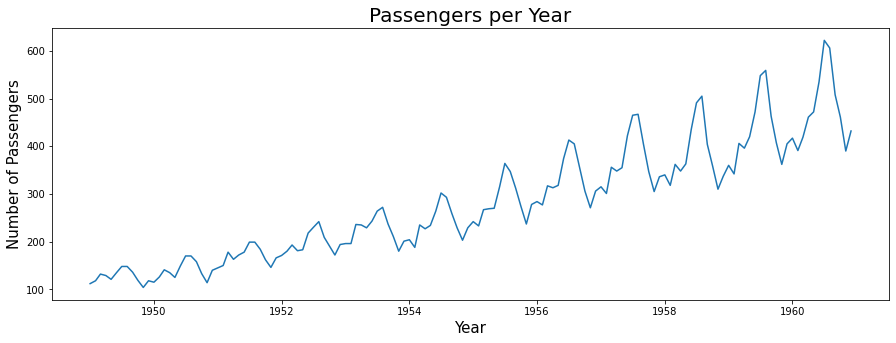

In [10]:
plt.plot(passengers['#Passengers'])

plt.xlabel('Year', fontsize = 15)
plt.ylabel('Number of Passengers', fontsize = 15)
plt.title('Passengers per Year', fontsize = 20)
plt.show()

We immediately see that the amplitude of the series is increasing with time, therefore we have a geometric series. On the other hand we can clearly identify a trend (the series moves upwards) and a sesonality (there is a periodic behaviour along the years). Let's transform the data set using logarithms and plot it again

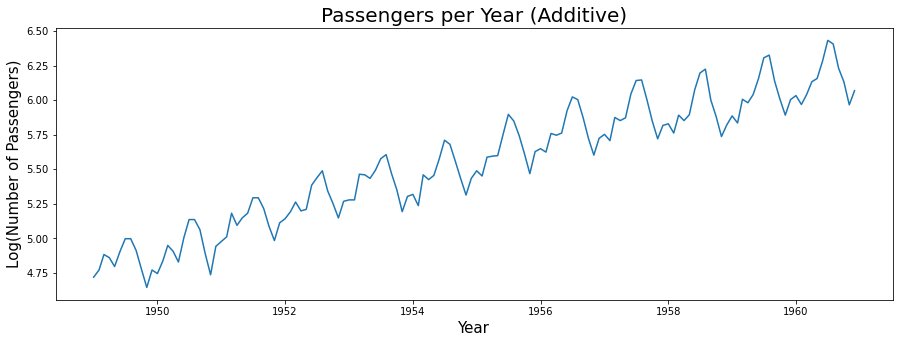

In [11]:
passengers['lpassengers'] = np.log(passengers['#Passengers'])

plt.plot(passengers['lpassengers'])

plt.xlabel('Year', fontsize = 15)
plt.ylabel('Log(Number of Passengers)', fontsize = 15)
plt.title('Passengers per Year (Additive)', fontsize = 20)

plt.show()

It is clear that now the amplitude does not change along the time, therefore through the logarithmic transformation we have obtained the desired arithmetic series. Now, let's decompose this time series in order to see its components

In [12]:
decomposition = seasonal_decompose(passengers['lpassengers'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

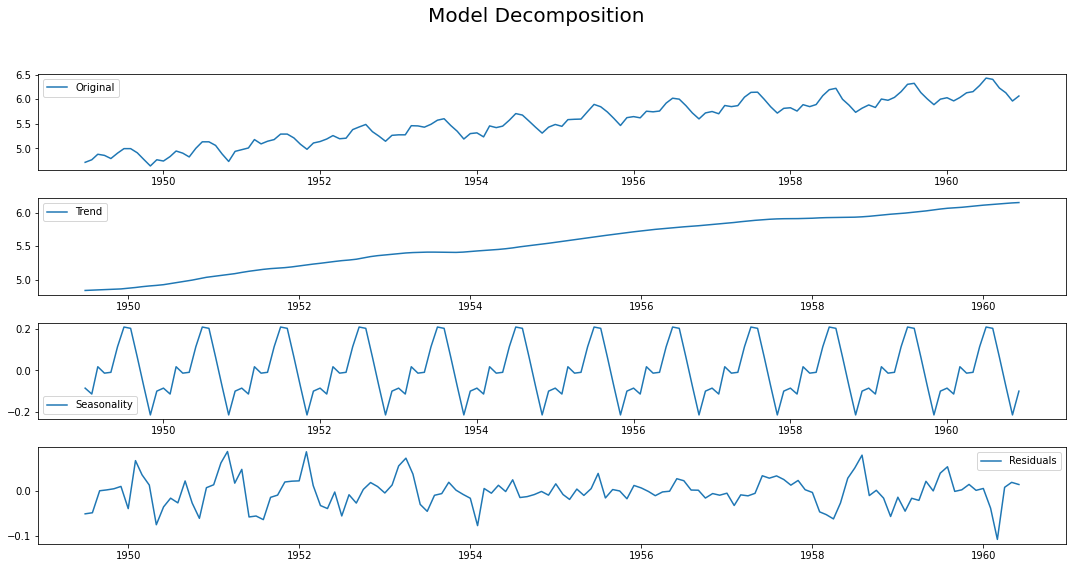

In [13]:
plt.figure(figsize = (15,8))
plt.suptitle('Model Decomposition', fontsize = 20)

plt.subplot(411)
plt.plot(passengers['lpassengers'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

## Stationarity

different models that we may consider in the Time Series context which may be divided into **stationary** and **non-stationary**. A process is known as stationary if its statistical characteristics do not change over time, i.e. if, for example, its mean or its standard deviation are constant along the whole process. 

Formally it can be seen that stationarity has to do with the joint distribution of the process as it evolves in time. Then we say that a series is **strictly stationary** if 

$$
P(x_{t_1}\leq c_1,\dots x_{t_n}\leq c_n)=P(x_{t_1+h}\leq c_1,\dots x_{t_n+h}\leq c_n)
$$

however, requiring this condition is too much for most applications


and joint distributions can be described as dependent or independent. In this context we can find

  * **(Highly) Persistent** (strongly dependent) time series, when an infinitesimal shock affects future time values. The longer the persistence, the longer the *memory* of the system.
  * **Weakly Dependent** time series, when both, the mean value is constant and does not depend on time and the autocovariance function depends only in the difference between the time moments, $|s-t|$, and not on the location of the two points. 

From now on, whenever we say *stationary* we actually mean *weakly dependent*. 

For our case before of the three-point moving average white noise, we can find that the mean is 0, because it is white noise and the moving average does not change this, while the autocorrelation function is

$$
\rho_v(h)=\left\{\begin{array}{ll} 1, & h=0\\\frac{2}{3},  & h=\pm 1\\\frac{1}{3},  & h=\pm 2\\0, & |h|>2\end{array}\right.
$$

which only depends on the lag. We can plot it as follows

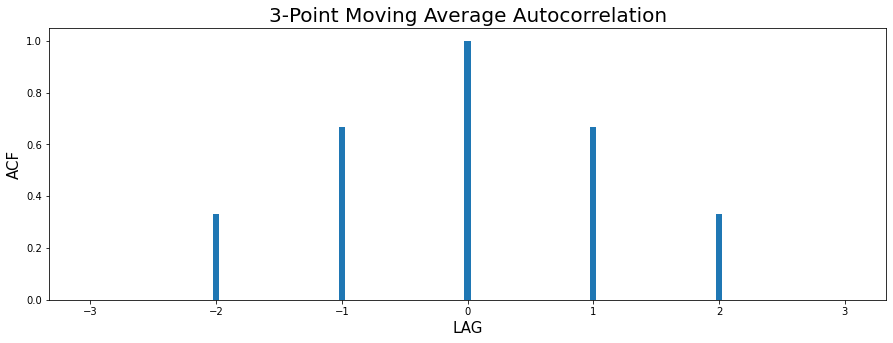

In [14]:
acf = pd.DataFrame({'ACF': [0, 1/3, 2/3, 1, 2/3, 1/3, 0],
                    'LAG': [-3, -2, -1, 0, 1, 2, 3]})

plt.bar(acf['LAG'], acf['ACF'], width = 0.05)
plt.title("3-Point Moving Average Autocorrelation", fontsize = 20)
plt.xlabel("LAG", fontsize = 15)
plt.ylabel("ACF", fontsize = 15)
plt.show()

#### Example

Let's analyse the stationarity of the `AirPassengers` data set. A common approach is to smooth the dataset through the **centered moving averages**, defined as

$$
smooth = \frac{y_{t-q}+\dots + y_y+\dots +y_{t+q}}{2k+1}
$$

we can find this quantity using the `rolling` function and specifying a window

In [15]:
m_aver = passengers['lpassengers'].rolling(12).mean()
std_aver = passengers['lpassengers'].rolling(12).std()

note that depending on the window we choose we will smooth the series more or less, for example

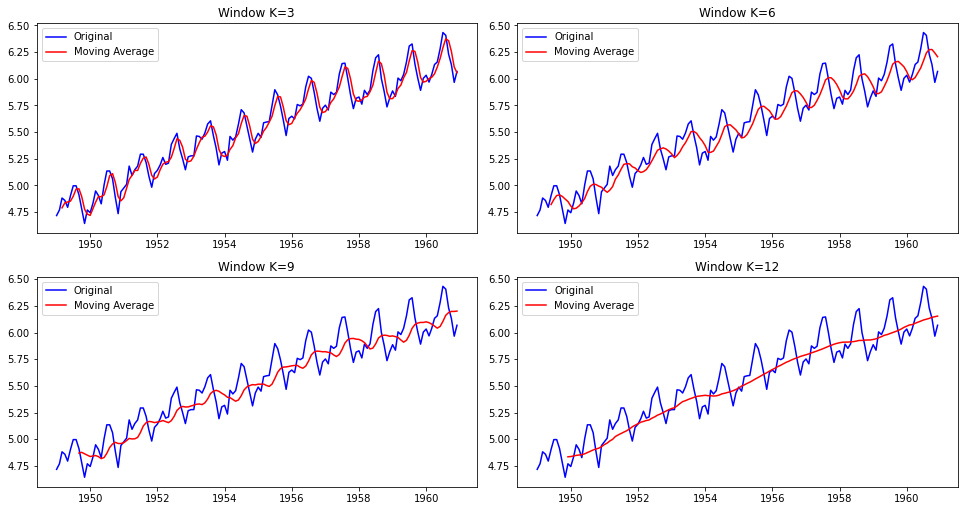

In [16]:
windows = [3, 6, 9 , 12]
coords = [(0,0), (0,1), (1,0), (1,1)]

plt.figure(figsize = (15,8))
for i,j in zip(windows, coords):
    m_aver = passengers['lpassengers'].rolling(i).mean()
    
    plt.subplot2grid((2,2), j)
    plt.plot(passengers['lpassengers'], color='blue',label='Original')
    plt.plot(m_aver, color='red', label='Moving Average')
    plt.title(f'Window K={i}')
    plt.legend(loc='best')

plt.tight_layout(rect=(0,0,0.9,0.9))
plt.show()

In the previous computation we have chosen a window of 12 months, which looks a rather natural periodicity in this case. Then we can plot it as

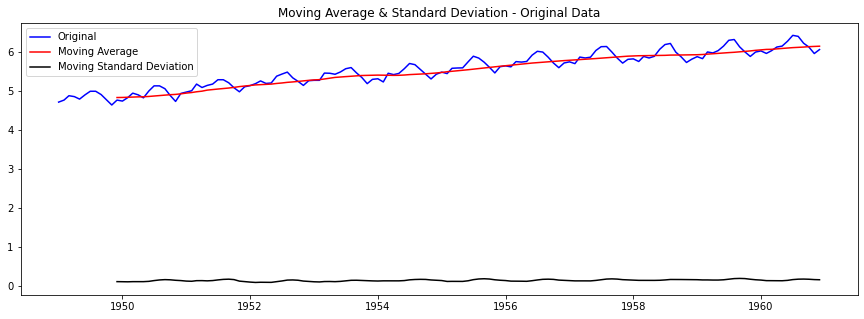

In [17]:
orig = plt.plot(passengers['lpassengers'], color='blue',label='Original')
mean = plt.plot(m_aver, color='red', label='Moving Average')
std = plt.plot(std_aver, color='black', label = 'Moving Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average & Standard Deviation - Original Data')
plt.show(block=False)

from where we immdiately see that while the variance may be considered as constant, the mean is not and, therefore, we do not have a stationary model. We may want to use a formal test to detect it: the **Augmented Dickey-Fuller test**

### Removing Trends

In this section we are going to deal with the easiest form of non-stationary process, the **trend stationary** model, where the model has a stationary process around a trend. We may write it as

$$
x_t=y_t+\mu_t
$$

where $y_t$ is the stationary process and $\mu_t$ is the trend. We are going to see two common techniques:

 * **Detrending**, where we use a linear regression model to **estimate** the trend, $\hat\mu_t$, and then write the stationary process as
 
 $$
 y_t=x_t-\hat\mu_t
 $$
 
 which should be (seaonalities appart) just the irregular component of the series.
 
 * **Differencing**, if we prefer not estimating any parameters in the process, we may model the trend as a **random walk with drift**, $\mu_t=\delta+\mu_{t-1}+w_t$, where $\delta$ is the drift and $w_t$ is a white noise independent of $y_t$, then the difference
 
 $$
 x_t-x_{t-1}=\delta+w_t+y_t-y_{t-1}
 $$
 
 is a stationary process due to the stationarity of $y_t$.

#### Detrending

The trend variable must be understood as containing all the effects correlated with the response that we do not consider explicitely in the regressors included in the model and that affect its behaviour. Then, once we add this trend variable we are **detrending** the time series.

The interpretation of this detrending is the following. Suppose we have the estimated detrended model

$$
\hat y_t = \hat\beta_0 + \hat\beta_1\,x_{t} + \hat\beta_2\,t
$$

The estimation of the coefficients in this detrended time series can be obtained in the following way. 

  * First regress all the variables involved in the model on a constant and the time only and obtain the residuals for each of these models (in our case we only have the response, so we may just need one set of residuals). The residuals must be thought as being *linearly detrended*, since they are
  
  $$
  \hat e_{y,t} = y_t - \hat\beta_0 - \hat\beta_2 t 
  $$
  
  i.e. we are substracting the trend.
  
  * Next we run the regression of the residuals on the residuals (without constant term now). The estimates of the slopes of this model are precisely
  
  $$
  \hat e_{y,t} = \hat\beta_1\hat e_{x_1,t}
  $$

How should we understand this result? First, we conclude that if the trend variable is relevant in our model, we should not trust the results without the trend. Second, that as soon as any of th independent variables shows is trending we should add the trend even if the response is not trending. Third, that if we do not add the trend we may see that one or more variables are related to the response wimply because they exhibit a trend.

Let's work with the logarithmic transformed variable, note that since we do not have any other variable to include in the model, we do not need to go through the second step to estimate the slopes of those variables, then


In [18]:
passengers['time']= [i+1 for i in range(passengers.shape[0])]

trend=ols('lpassengers ~ time', data=passengers).fit()
passengers['detrended'] = passengers['lpassengers']-trend.fittedvalues

we will plot this result together with the output in the differences method

#### Differences method

To better understand the differences and since it plays a crucial role in time series, we are going to introduce the the **back-shift operator**, $B$, defined as

$$
B^kx_t= x_{t-k}
$$

with this we can define the **differences of order $d$** as

$$
\nabla^d = (1-B)^d
$$

The first difference is an example of what is known as a *linear filter*, applied to remove the linear trend of a series. Then for a model with trend

$$
x_t = \mu_t + y_t
$$

with $y_t$ a stationary process, it can be proved that 

$$
\nabla x_t = x_t - x_{t-1}
$$

has an autocovariance depending only on the lags and is, therefore, weakly stationary. If, on the other hand we detect a quadratic trend, we should use the second differences, i.e.

$$
\nabla^2 x_t = x_t - 2x_{t-1} + x_{t-2}
$$

Note that once we want to find the predictions (forecasting), we need to un-difference the series, a process that is known as **integration**

This method is not free from problems:

  * we lose observations, and
  * since we do not estimate the stationary process
  
then if we need an estimation of the stationry process we should rather use the detrending, but if we just need to remove the trend, then it is much better to use differences.

Let's find the differences for the log transformed variable as before and then plot both results

In [19]:
passengers['difference'] = passengers['lpassengers'] - passengers['lpassengers'].shift()

We are now ready to plot a comparison of both methods

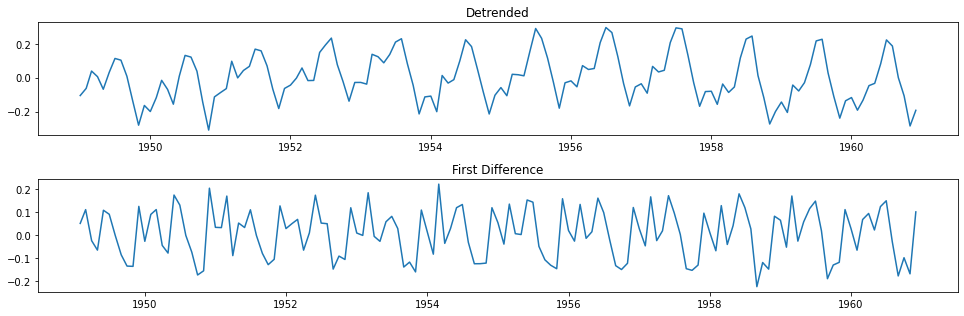

In [20]:
plt.subplot(211)
plt.plot(passengers['detrended'])
plt.title('Detrended')

plt.subplot(212)
plt.plot(passengers['difference'])
plt.title('First Difference')

plt.tight_layout(rect=(0,0,0.9,0.9))
plt.show()

We can immediatly see that both procedures result in time series in which the trend has been removed although we can see the seasonality very clearly. If we want to perform a formal test, we may go with ADF, then 

In [21]:
print('Results of Dickey-Fuller Test for DETRENDING:')
dftest = adfuller(passengers['detrended'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 
                                           'p-value', 
                                           'Number of Lags Used', 
                                           'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

print('\n\nResults of Dickey-Fuller Test for DIFFERENCE:')
dftest = adfuller(passengers['difference'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 
                                           'p-value', 
                                           'Number of Lags Used', 
                                           'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test for DETRENDING:
Test Statistic                  -2.260662
p-value                          0.184969
Number of Lags Used             13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Results of Dickey-Fuller Test for DIFFERENCE:
Test Statistic                  -2.717131
p-value                          0.071121
Number of Lags Used             14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Remember that in this case $H_0$ is the non-stationary, therefore, in order to have a stationary process we may need to reject the NULL, i.e. find a pvalue smaller than the significance level. In this sense, the results above do not produce too nice results but in both cases we may trace the problems back to seasonality (see below). In any case, at least, for a 10%, we may claim stationarity of the differences time series.

### Seasonality

Once the trend is removed, we may focus on the seasonal component of the time series. There are different approaches to deal with this. For example,

 * **Graphically**, we may perform a seasonal plot where we can see the time subseries for the different seasons
 * **Linear Regression**, we may remove seasonality by adding $n-1$ dummy viariables, where $n$ is the order of the seaonality, for example, if we consider a year, we may add 11 variables corresponding to the months
 * **Differences**, we may consider the difference of order $n$, where $n$ is the seasonality order of the differenced time series, for example 12 if we consider a year.
 
Let's use the difference method (since it is going to be important in ARIMA), then we can make the following plot beginning with the original time series, then the logarithmic transformed, the first difference and finally the seasonal difference of order 12

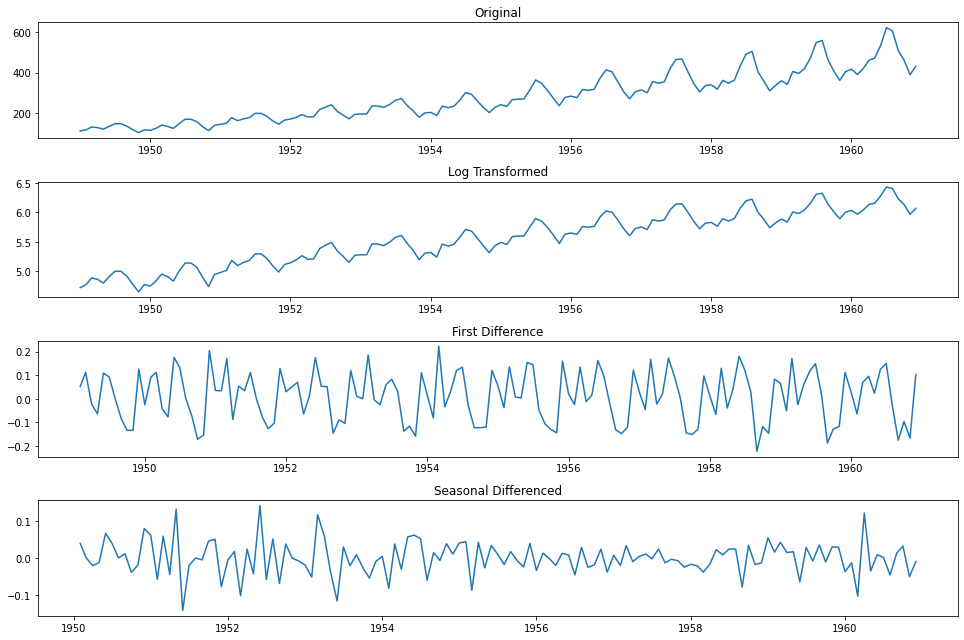

In [22]:
plt.figure(figsize=(15,10))

plt.subplot(411)
plt.plot(passengers['#Passengers'])
plt.title('Original')

plt.subplot(412)
plt.plot(passengers['lpassengers'])
plt.title('Log Transformed')

plt.subplot(413)
plt.plot(passengers['difference'])
plt.title('First Difference')

plt.subplot(414)
plt.plot(passengers['difference'].diff(12))
plt.title('Seasonal Differenced')

plt.tight_layout(rect=(0,0,0.9,0.9))
plt.show()

finally we see that the last time series, the Seasonal Differenced, is stationary

In [23]:
print('Results of Dickey-Fuller Test for SEASONAL DIFFERENCED:')
dftest = adfuller(passengers['difference'].diff(12).dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 
                                           'p-value', 
                                           'Number of Lags Used', 
                                           'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test for SEASONAL DIFFERENCED:
Test Statistic                  -4.443325
p-value                          0.000249
Number of Lags Used             12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


#### Season Plot

We may want to make other plots, one possibility is the season plot, where we use the seasonality of the time series to make a comparison of each of the different series, this may be done, for example using

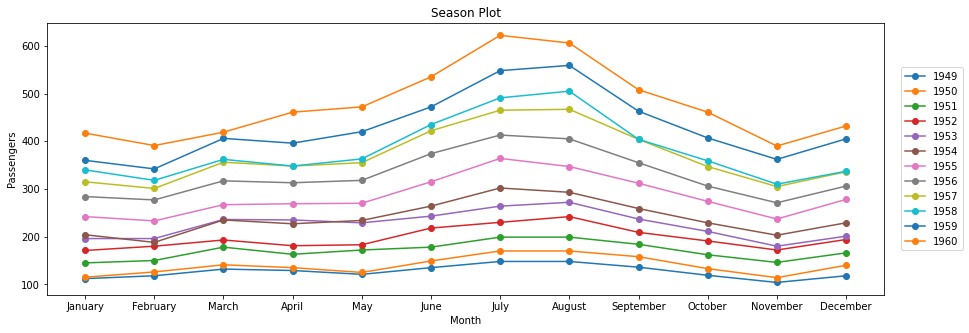

In [24]:
groups=passengers['#Passengers'].groupby(pd.Grouper(freq='A'))
years=pd.DataFrame()

for name,group in groups:
    years[name.year]=group.values

years.index = [i for i in calendar.month_name[1:]]
years.plot(legend=False, marker='o')
plt.title('Season Plot')
plt.xlabel('Month')
plt.xticks(np.arange(12), years.index)
plt.ylabel('Passengers')
plt.legend(loc='right', bbox_to_anchor=(1.1,0.5))
plt.show()

Note that this also allow us to detect a non-stationary behaviour, since the magnitudes of series increase with time and also that the amplitude of the series is also increasing, and therefore we have a geometric scheme.

## (S)ARIMA Models

Once we have performed the EDA of our time series, let's move on to the modelization using an (S)ARIMA model, Seasonal Autorregresive Integrated Moving Average Model. Firt let's explain the Box-Jenkins methodology and then find the model

### Box-Jenkins Methodology

Let's now make a summary of the general Box-Jenkins methodology for ARIMA models:

 * **Collect the data**: Box and Jenkins recommend a minimum of 50 observations and, when working with monthly series have between 6 and 10 years of information (similar bounds for other seasonal periods).
 * **Represent the series**: Always make the graphical representation of the series. This may let us identify different properties as schemes, trends or stationarity. An interesting tool is that of the moving averages or standard deviations to detect if the statistical properties are changing with time.
 * **Transform the series**: If the series is not stationary or we detect a precise scheme we should always consider the transformation of variables. Typically into logarithms, but we can do a more general Box-Cox type transformation.
 * **Remove trends**: By decomposition or by direct observation of the graph we can detect the existence and type of a trend. There are different ways to remove it: differences or analytically. In the ARIMA model we can consider that if the trend is **linear** then we take d=1 and for a non-linear trend we use d=2 (the python function does not allow for higher values of d).
 * **Identify the model**: Identify the order of the autorregressive and moving averages of the regular and seasonal components. In absence of any other guide, take $(p, q)\in[1,2]$ with all their combinations. These values should be found by means of the autocorrelation or partial correlation functions and graphs (take a look at the **acf** and **pacf** functions from **statsmodels.tsa.stattools** module as well as to the **plot_acf** and **plot_pacf** from statsmodels.graphics.tsaplots) as well as by minimization of the different information criteria. If we have doubts with respect to which model we should take, estimate some of them and compare later (with respect to this, see if the ARIMA(2,1,2) would be better than the ARIMA(3,1,3) we have found before)
 * **Estimate the coefficients**: Usual estimation process.
 * **Validate the model**: There are many different tests that can be made to validate the model. One option similar to one that we have covered in linear regression is that when the model does not actully fit the observed series, the residuals will be autocorrelated values. In this case we should use **Durbin-Watson** for first order autocorrelation or **Wallis** for fourth order autocorrelations.
 * **Analyize the errors**: This is the usual residuals study, mostly looking for high residual points (outliers) where the difference between the prediction and the observed values is too different
 * **Select the model**: In view of the previous steps, select one of the models.
 * **Forecasting**: Once we have the model we can use it as the basis for forecasting.

### ARIMA Model

The ARIMA models, or ARIMA(p,d,q), are weakly dependent models obtained from a combination of different submodels. In general we can write the model as

$$
\left(1-\sum_{i=1}^p\phi_iB^i\right)(1-B)^d y_t = \left(1-\sum_{i=1}^q\alpha_iB^i\right)e_t
$$

or, in a more concise way, as

$$
\phi(B)\nabla^d\,x_t=\theta(B)\,w_t
$$


#### AR(p)

These **autoregressive processes of order p**, AR(p) or ARIMA(p,0,0), models are based on the idea that current values of the series depend on previous values of the same series, hence the name, and are written generally as

$$
x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \dots+ \phi_q x_{t-q} + w_t
$$
  
For the particular case of $p=1$, we have the AR(1) or ARIMA(1,0,0) written as
  
$$
x_t = \phi x_{t-1} + w_t
$$
  
where the autoregressive terms are lags of the dependent variable. The number $p$ represents, again the number of terms to be included in the equation, so the previous is an AR(1) model. Making contact with our analysis of trends, see that if $\phi=1$ this model is a **random walk** without drift.

In general we can write these models using the **Autoregresive Operator**, defined as

$$
\phi(B)=1-\phi_1\,B-\phi_2\,B^2-\dots-\phi_p\,B^p
$$

as

$$
\phi(B)x_t=w_t
$$

#### I(d)

This integrated part corresponds just to the differences of order d that we have seen before, then we may say that they are directly written as

$$
(1-B)^dx_t =  w_t
$$

the case of I(1) corresponds to the usual difference time series, since $B$ is the back-shift operator, then
  
$$
(1-B)x_t = x_t - x_{t-1} = w_t
$$

#### MA(q)

Alternatively, we may consider that it is a combination of the white noise which is responsible of the current value of the time series. In this case we will consider the **Moving Average processes of order q**, MA(q) or ARIMA(0,0,q).

As before we are going to introduce the **Moving Average Pperator** as

\begin{equation}
\theta(B)=1+\theta_1\,B+\theta_2\,B^2+\dots\theta_q\,B^q
\end{equation}

then the model can be written generally as

\begin{equation}
y_t = \theta(B)e_t = w_t - \theta_1\,w_{t-1} - \theta_2\,w_{t-2} -\dots - \theta_p\,w_{t-p}
\end{equation}
  
in particular, for $q=1$, the model MA(1) or ARIMA(0,0,1) is

\begin{equation}
y_t = w_t + \alpha\,w_{t-1}
\end{equation}
  
where the moving averages are lagged forecast errors in the prediction equation. The number $q$ represents the number of terms to be included in the equation (the equation we have written is a case for MA(1). This model MA(1) is a stationary, weakly dependent sequence).

### Identifying the Orders

All the work corresponding to the integrated part has already been done in the section for the trend. In that case, we have identified a linear trend in the passengers case and, therefore, an order of 1 is what we may use. The AR and MA parts are a bit more subtle and a good approach is through the use of the ACF and PACF functions. 

When we plot the functions for an arbitrary large number of lags, their behaviours can be summarized as follows

<br>
<table>
<tr>
<th></th><th> AR(p) </th><th> MA(q) </th><th> ARMA(p,q) </th>
</tr>
<tr>
<td> ACF </td><td> Tails Off </td><td> Cuts off after lag q </td><td> Tails off </td>
</tr>
<tr>
<td> PACF </td><td> Cuts off after lag p </td><td> Tails off </td><td> Tails off </td>
</tr>
</table>
<br>

Let's plot the ACF and PACF in our case of the air passengers. We are going to plot it for two cases: logs and difference

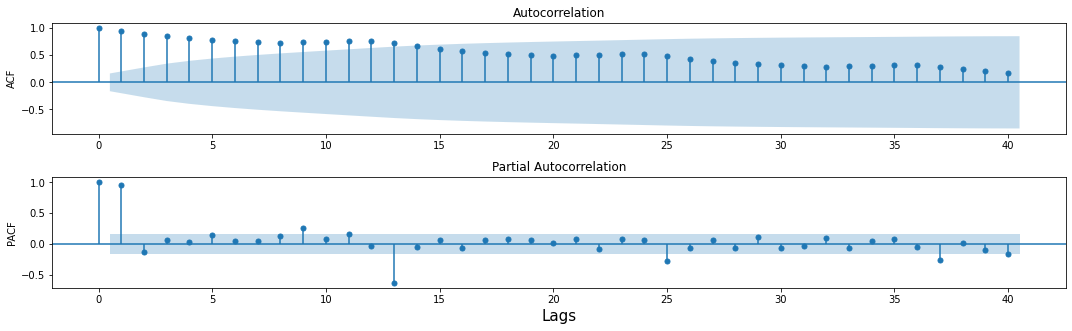

In [25]:
plt.subplot(211)
plot_acf(passengers['lpassengers'].dropna(), lags = 40, ax = plt.gca())
plt.ylabel('ACF')

plt.subplot(212)
plot_pacf(passengers['lpassengers'].dropna(), lags = 40, ax = plt.gca())
plt.ylabel('PACF')
plt.xlabel('Lags', fontsize = 15)

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

In this case, the fact that the ACF function decreases so slowly is an indicative of its non-stationary nature, but taking the table above, since the PACF cuts at lag 1, this may be indicating that the model would be described as an ARIMA(1,1,0). Let's deal with the differenced time series

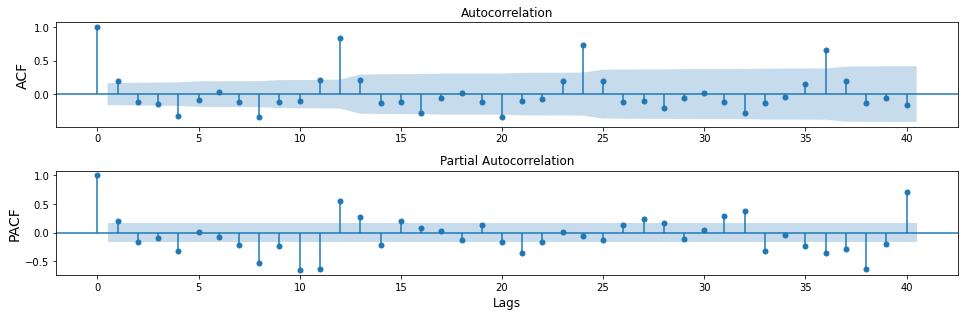

In [26]:
plt.subplot(211)
plot_acf(passengers['difference'].dropna(), lags = 40, ax = plt.gca())
plt.ylabel('ACF', fontsize = 14)

plt.subplot(212)
plot_pacf(passengers['difference'].dropna(), lags = 40, ax = plt.gca())
plt.ylabel('PACF', fontsize = 14)
plt.xlabel('Lags', fontsize = 12)

plt.tight_layout(rect = (0,0,0.9,0.9))
plt.show()

we see that there is a tailing off in the ACF each 12 lags, due to the seasonality and then we need the deseasonalized time series to better deal with the model. However, this 

### SARIMA Model

The SARIMA models, or ARIMA$(p,d,q)(P,D,Q)_m$, an enhacement of ARIMA in order to include the seasonal component of the time series. We can write it as

$$
\phi_P(B^s)\phi(B)\nabla_s^D\nabla^d\,x_t=\theta_Q(B^s)\theta(B)\,w_t
$$

where the order $m$ is the seasonal order (12, for example in the passengers case) and $D$ is the difference in seasons to consider (1, for example in the passengers case). In this case the orders of the model can also be obtained from the ACF and PACF plots

<br>
<table>
<tr>
<th></th><th> AR$(P)_s$ </th><th> MA$(Q)_s$ </th><th> ARMA$(P,Q)_s$ </th>
</tr>
<tr>
<td> ACF </td><td> Tails Off at $ks$ lags</td><td> Cuts off after lag $Qs$ </td><td> Tails off at $ks$ lags</td>
</tr>
<tr>
<td> PACF </td><td> Cuts off after lag $Ps$ </td><td> Tails off at $ks$ lags</td><td> Tails off at $ks$ lags</td>
</tr>
</table>
<br>

In the ACF and PACF plots of the difference above we identified a tailing off in the ACF and a cut off in the PACF at lag 1 (in seasons). We need, however, the seasonal differenced model, then

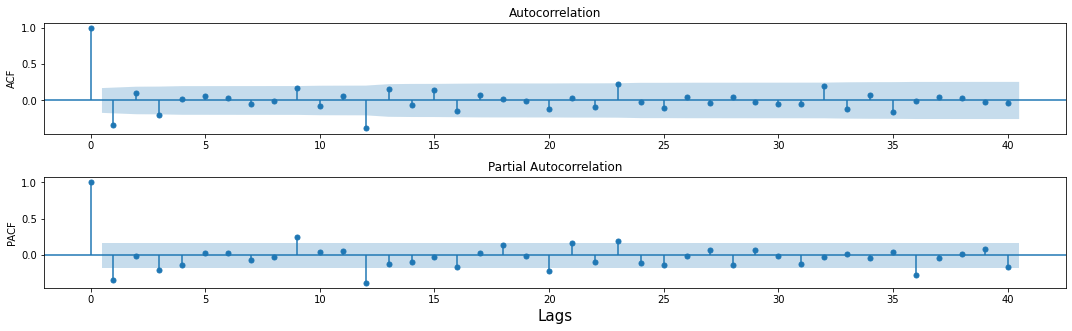

In [27]:
plt.subplot(211)
plot_acf(passengers['difference'].diff(12).dropna(), lags = 40, ax = plt.gca())
plt.ylabel('ACF')

plt.subplot(212)
plot_pacf(passengers['difference'].diff(12).dropna(), lags = 40, ax = plt.gca())
plt.ylabel('PACF')
plt.xlabel('Lags', fontsize = 15)

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

in this case for the seasonal components, ACF cuts at lag 1, while PACF tails off, which points to SMA(1), and from the non-seasonal components it looks like both functions are tailing off, suggesting an ARMA(1,1). Overall the model points to ARIMA$(1,1,1)(0,1,1)_{12}$, then let's fit it

In [28]:
sarima_1 = sm.tsa.SARIMAX(passengers['lpassengers'], order = (1,1,1), seasonal_order = (0,1,1,12)).fit()
print(sarima_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        lpassengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Sat, 24 Apr 2021   AIC                           -481.893
Time:                                    11:25:42   BIC                           -470.392
Sample:                                01-01-1949   HQIC                          -477.220
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1967      0.199      0.988      0.323      -0.193       0.587
ma.L1         -0.5789      0.171   

Note that from the model, the coefficient for the AR part seems irrelevant and then we may drop it to fit an ARIMA$(0,1,1)(0,1,1)_{12}$

In [29]:
sarima_2 = sm.tsa.SARIMAX(passengers['lpassengers'], order = (0,1,1), seasonal_order = (0,1,1,12)).fit()
print(sarima_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        lpassengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Sat, 24 Apr 2021   AIC                           -483.393
Time:                                    11:25:42   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.502      0.000      -0.545      -0.259
ma.S.L12      -0.5570      0.096   

Looking at the information criteria of both models, we may conclude that the ARIMA$(0,1,1)(0,1,1)_{12}$ is a better model.

#### Diagnosis Plots

Just like for any model, we may perform a basic validation of the model through a graphi8cal analysis. In this case we have a good set of functions for it

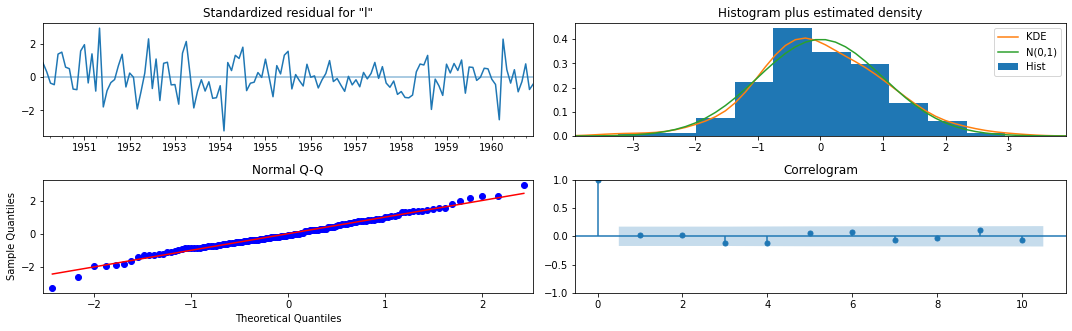

In [43]:
sarima_2.plot_diagnostics()
plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

#### Prediction

We can use the SARIMA model above to see the fit to the original values, for this we first find the predictions

In [31]:
prediction = pd.DataFrame({'Number of Passengers': sarima_2.predict(n_periods=185)}, 
                          index = passengers['lpassengers'].index)
prediction.loc['1950-01-01']=4.795571

we have manually changed a value that seemed strange by a fit using other method (Don't do this!), and you may also remove the initial value of 0 which comes from the shifts. Now we can plot the time series as

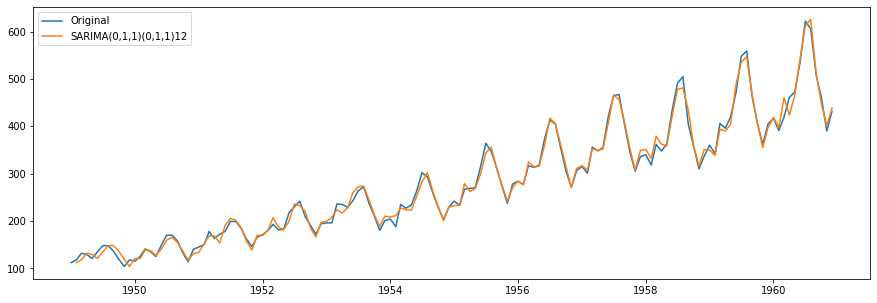

In [32]:
plt.plot(passengers['#Passengers'], label='Original')
plt.plot(np.exp(prediction)['1949-02-01':], label='SARIMA(0,1,1)(0,1,1)12')

plt.legend(loc = 'best')
plt.show()

from where we see a good fit to the original time series.

#### Forecasting

Let's now forecast. in the `get_forecast` function that we are going to use we must give as argument the number of steps to forecast, there you can use any value from 1 to the length of the test set to be used. Let's see how it works in a 1-step forescast

In [33]:
fc = sarima_2.get_forecast(steps = 1)
fc.conf_int(), fc.predicted_mean

(            lower lpassengers  upper lpassengers
 1961-01-01           6.038226           6.182144,
 1961-01-01    6.110185
 Freq: MS, dtype: float64)

it returns the next value off the dataset and we are going to use this to predict the next year, i.e., 12 steps

In [34]:
fc = sarima_2.get_forecast(steps = 12)
yhat = fc.predicted_mean
for_ci = fc.conf_int()

let's plot the original time series and the forecast

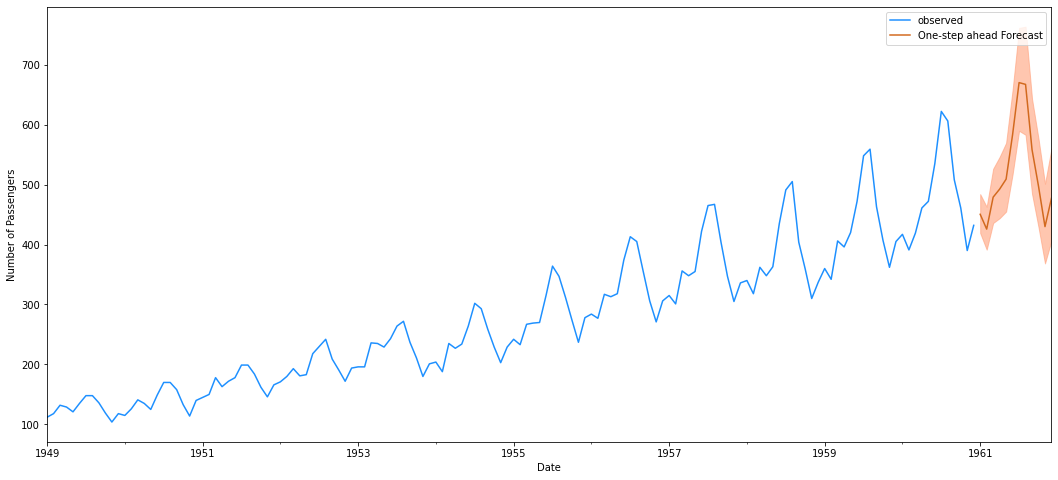

In [35]:
passengers['#Passengers'].plot(label='observed', color = 'dodgerblue')
np.exp(yhat).plot(label='One-step ahead Forecast', color = 'chocolate', figsize=(18, 8))
plt.fill_between(for_ci.index,
                np.exp(for_ci).iloc[:, 0],
                np.exp(for_ci).iloc[:, 1], color='lightsalmon', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend(loc='best')
plt.show()

If you want to forecast in order to compare with the dataset, i.e. use a part of the data as test set, you must fit the SARIMA model using only the training set and the you forecast and compare. You could, for example, leave the last year out and then perform the forecast:

In [36]:
post = passengers['1960-01-01':]
pre = passengers[:'1960-01-01']

### Auto-ARIMA

We may use the `auto_arima` function in the `pmdarima` module in order to find the optimum model. We just need to seed it with some parameters and it will proceed by comparing the AIC of the different models

In [37]:
from pmdarima.arima import auto_arima

with our knowledge, we know that $d=1$, $D=1$ and $m=12$, then let's run up to a value of 3 in $p,q, P, Q$ and see

In [38]:
auto = auto_arima(passengers['lpassengers'],
                  max_p=3,
                  max_q=3,
                  d=1, 
                  max_P=3,
                  max_Q=3, 
                  m=12, 
                  D=1, 
                  seasonal=True, 
                  stepwise=True,
                  suppress_warnings=True,
                  trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-477.723, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=0.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=1.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=0.59 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.25 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1

the output of the function is the same we have obtained before: the best solution is ARIMA$(0,1,1)(0,1,1)_{12}$.

## DataSets

You can explore some datasets in `statsmodels` for time series as for example

In [39]:
sm.datasets.elnino.load_pandas().data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [40]:
sm.datasets.nile.load_pandas().data.head()

,year,volume
0,1871.0,1120.0
1,1872.0,1160.0
2,1873.0,963.0
3,1874.0,1210.0
4,1875.0,1160.0


or you may want to download data from the stock market using `yahoo_fin`, then you just write

```python
from yahoo_fin.stock_info import get_data
```

and then to get data from google, you just need the code and the dates

```python
google = get_data('goog', start_date = '01/01/2019', end_date = '10/27/2020')
google.head()
```